In [1]:
# import required modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from itertools import cycle
from scipy.stats import sem  # 标准误差
from scipy.interpolate import make_interp_spline
# utilities
colors = ['#FF800E','#006BA4','#006BA4', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', 
          '#A2C8EC', '#FFBC79', '#CFCFCF']
markers = ["p","v","X","o","s",
           "P","^","d","<",
           "3","*",">"]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    'text.usetex': True,  # 启用 LaTeX 引擎
    'font.family': 'serif',  # 设置字体为 serif（常用的 LaTeX 字体）
    'font.serif': ['Times New Roman'],  # 选择 Times New Roman 字体，或者其他 LaTeX 默认字体
})

In [2]:
# plot the learning curves of HySRL and BPI-VI
def plot_learning(N,T,online_reward,hybrid_reward):
    # N, the number of agents
    # T, the number of episodes

    # mean reward and std error
    mean_reward_online=np.mean(online_reward,axis=0)
    std_err_online=sem(online_reward,axis=0) #calculate standard error
    mean_reward_hybrid=np.mean(hybrid_reward,axis=0)
    std_err_hybrid=sem(hybrid_reward,axis=0) #calculate standard error
    #calculate confidence interval
    confidence_interval_online=1.96*std_err_online/np.sqrt(N) #95%
    confidence_interval_hybrid=1.96*std_err_hybrid/np.sqrt(N) #95%
    # sample size
    x=np.arange(T//100)*2000

    # smoothen the curve
    x_smooth = np.linspace(x.min(), x.max(), 350) 
    spl_mean_online = make_interp_spline(x, mean_reward_online, k=3)  # B样条插值
    spl_mean_hybrid = make_interp_spline(x, mean_reward_hybrid, k=3)

    y_smooth_online = spl_mean_online(x_smooth)
    y_smooth_hybrid = spl_mean_hybrid(x_smooth)

    spl_ci_upper_online = make_interp_spline(x, mean_reward_online + confidence_interval_online, k=3)
    y_smooth_upper_online = spl_ci_upper_online(x_smooth)

    spl_ci_lower_online = make_interp_spline(x, mean_reward_online - confidence_interval_online, k=3)
    y_smooth_lower_online = spl_ci_lower_online(x_smooth)

    spl_ci_upper_hybrid = make_interp_spline(x, mean_reward_hybrid + confidence_interval_hybrid, k=3)
    y_smooth_upper_hybrid = spl_ci_upper_hybrid(x_smooth)

    spl_ci_lower_hybrid = make_interp_spline(x, mean_reward_hybrid - confidence_interval_hybrid, k=3)
    y_smooth_lower_hybrid = spl_ci_lower_hybrid(x_smooth)

    # draw the mean curves
    plt.plot(x_smooth, y_smooth_online,color=colors[1],label='BPI-UCBVI (online)')
    plt.plot(x_smooth, y_smooth_hybrid,color=colors[0], label='HySRL (ours)')
    # draw the confidence intervals
    plt.fill_between(x_smooth, y_smooth_lower_online, y_smooth_upper_online, color=colors[1], alpha=0.2)
    plt.fill_between(x_smooth, y_smooth_lower_hybrid, y_smooth_upper_hybrid, color=colors[0], alpha=0.2)
    # add labels
    plt.xlabel("Sample size N", fontsize=20)
    plt.ylabel(r"$V^{p_{\mathrm{tar}},\hat{\pi}}(\rho)$", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # add grids
    plt.tick_params(axis='both', which='both', labelsize=16)
    plt.savefig("1.pdf",bbox_inches='tight')
    plt.show()



In [7]:
# plot the optimality gap of HySRL and BPI-VI
def plot_opt_gap(N,hybrid_raw,online_raw,opt_v):
    # plot points(episodes)
    plot_point=[10000]+[20000*i for i in range(1,11)]
    # plot_point=[10000,40000,50000,59000,70000,90000,110000,150000,180000,200000]
    # plot_point=[100,1000,10000,20000,49800,100000,199000]
    # sample size
    sample_size=[i*20 for i in plot_point]
    # mean and confidence intervals(95%)
    online_mean=np.mean(online_raw,axis=0)
    hybrid_mean=np.mean(hybrid_raw,axis=0)
    online_std = np.std(online_raw, axis=0)*1.96/np.sqrt(N)
    hybrid_std = np.std(hybrid_raw, axis=0)*1.96/np.sqrt(N)
    # calculate opt-gaps
    hybrid_reward = [opt_v - hybrid_mean[n // 100 - 1] for n in plot_point]
    online_reward = [opt_v - online_mean[n // 100 - 1] for n in plot_point]
    hybrid_std_vals = [hybrid_std[n // 100 - 1] for n in plot_point]
    online_std_vals = [online_std[n // 100 - 1] for n in plot_point]
    print(hybrid_reward)
    print(online_reward)
    # plot
    markercycler = cycle(markers)
    colorcycler = cycle(colors)
    fig_opt, ax_opt = plt.subplots(1, 1,figsize=(8, 6))
    labels = ['HySRL (ours)', 'BPI-UCBVI (online)']
    sub_opt = [hybrid_reward,online_reward]
    sub_opt_std = [hybrid_std_vals, online_std_vals]    
    for i in range(len(labels)):
        color = next(colorcycler)
        marker = next(markercycler)
        # plot the mean value
        ax_opt.plot(sample_size, sub_opt[i], marker=marker, color=color, label=labels[i],
                        linewidth=1.5, markersize=6)
        # add confidence intervals (shaded area)
        ax_opt.fill_between(sample_size, 
                        np.array(sub_opt[i]) - np.array(sub_opt_std[i]), 
                        np.array(sub_opt[i]) + np.array(sub_opt_std[i]),
                        color=color, alpha=0.2) 
    
    # add labels
    ax_opt.legend(fontsize=20)
    ax_opt.grid(visible=True)
    ax_opt.set_ylabel(r"$V^{p_{\mathrm{tar}},\star}(\rho) - V^{p_{\mathrm{tar}},\hat{\pi}}(\rho)$", fontsize=24)
    ax_opt.set_xlabel(r"Sample size $N$", fontsize=24)
    ax_opt.set_ylim([0, 2.5])
    ax_opt.set_xlim([0, 4000000])
    ax_opt.tick_params(axis='both', which='both', labelsize=16)
    plt.savefig("gap-ci.pdf")
    fig_opt.tight_layout()



In [4]:
# plot when \beta is not correct
# the percentage optimality gaps of HySRL versus BPI-UCBVI
# sample size = 2 x 10^6, for both algorithms
# \beta=0.45 for HySRL
# maximum unidentified shift level 0.1,0.15,0.2,0.25,0.3,0.35,0.4
def plot_beta_ci(N,opt_hybrid_bar,opt_online_bar,opt_v,beta):
    # maximum unidentified 
    unseen_shift=[0.95-i for i in beta]
    # delete shift level
    opt_hybrid=[]
    opt_online=[]
    for i in range(0,8,1):
        opt_hybrid.append(opt_hybrid_bar[1+2*i][1:]/opt_v[i,1])
        opt_online.append(opt_online_bar[1+2*i][1:]/opt_v[i,1])
    opt_hybrid=np.array(opt_hybrid)
    opt_online=np.array(opt_online)
    # calculate mean v value and confidence interval
    opt_hybrid_mean=np.mean(opt_hybrid,axis=1)
    opt_online_mean=np.mean(opt_online,axis=1)
    opt_hybrid_ci=np.std(opt_hybrid,axis=1)*1.96/np.sqrt(N)
    opt_online_ci=np.std(opt_online,axis=1)*1.96/np.sqrt(N)
    # percentage optimality gaps
    gap_hybrid=[1-opt_hybrid_mean[i] for i in range(8)]
    gap_online=[1-opt_online_mean[i] for i in range(8)]
    # plot
    labels = ['HySRL (ours)', 'BPI-UCBVI (online)']
    markercycler = cycle(markers)
    colorcycler = cycle(colors)
    fig_opt, ax_opt = plt.subplots(1, 1,figsize=(8, 6))
    sub_opt = [gap_hybrid,gap_online]
    sub_opt_std = [opt_hybrid_ci, opt_online_ci]    
    for i in range(len(labels)):
        color = next(colorcycler)
        marker = next(markercycler)
        # plot the mean value
        ax_opt.plot(unseen_shift, sub_opt[i], marker=marker, color=color, label=labels[i],
                        linewidth=1.5, markersize=6)
        # add confidence intervals (shaded area)
        ax_opt.fill_between(unseen_shift, 
                        np.array(sub_opt[i]) - np.array(sub_opt_std[i]), 
                        np.array(sub_opt[i]) + np.array(sub_opt_std[i]),
                        color=color, alpha=0.2) 
    ax_opt.legend(fontsize=20)
    ax_opt.grid(visible=True)
    # add labels
    ax_opt.set_ylabel(r"$1- V^{p_{\mathrm{tar}},\hat{\pi}}(\rho)/V^{p_{\mathrm{tar}},\star}(\rho) $", fontsize=24)
    ax_opt.set_xlabel(r"True\,\,$\beta$", fontsize=24)
    ax_opt.set_ylim([0, 1])
    ax_opt.set_xlim([0.05, 0.4])
    ax_opt.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax_opt.tick_params(axis='both', which='both', labelsize=16)
    plt.savefig("percentage-drop-ci.pdf")
    fig_opt.tight_layout()

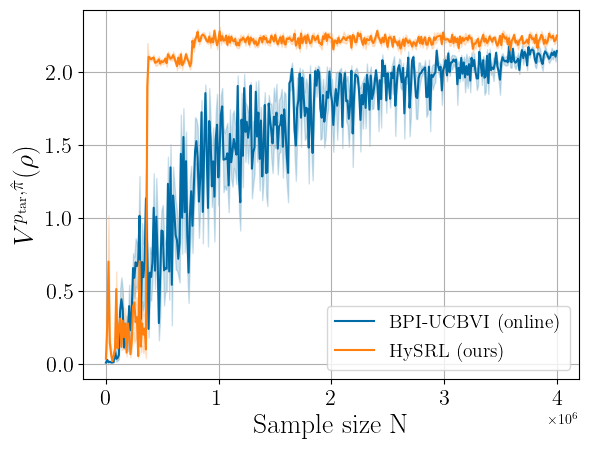

[2.03862, 0.16382000000000074, 0.05394000000000032, 0.06822000000000017, 0.021560000000000024, 0.027520000000000433, 0.02320000000000011, 0.10602, 0.03902000000000028, 0.05155999999999983, 0.029220000000000024]
[2.0642199999999997, 0.9691000000000001, 1.39864, 0.6680000000000001, 1.0884800000000003, 0.36944000000000066, 0.40104000000000006, 0.2770600000000001, 0.2827600000000001, 0.16708000000000034, 0.13527999999999984]


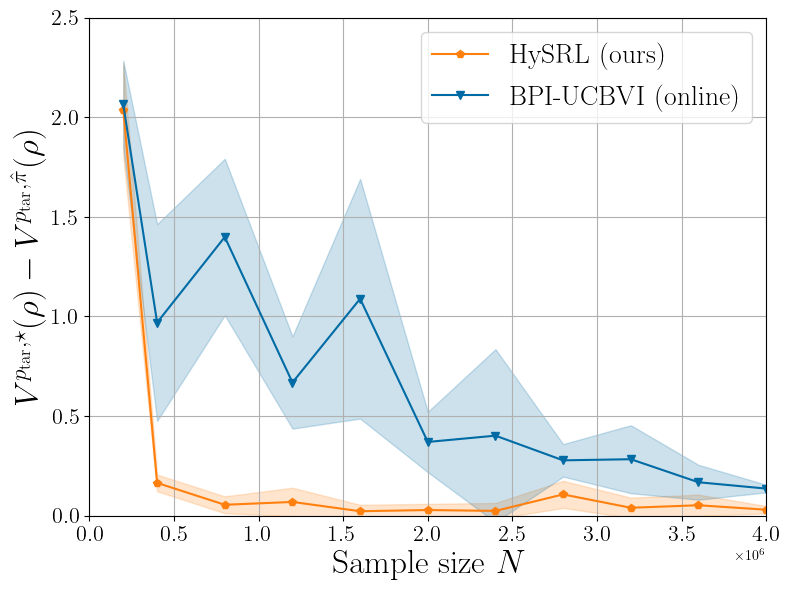

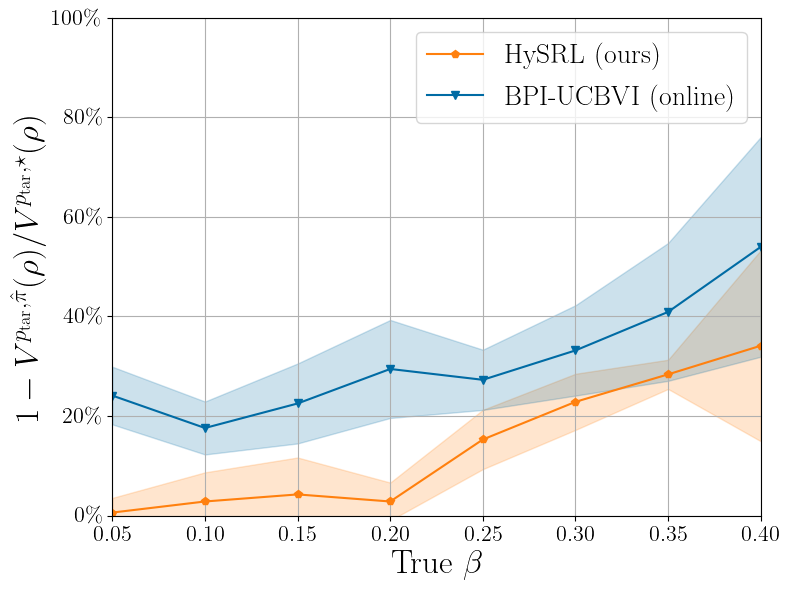

In [8]:
# plot the learning curves of HySRL and BPI-VI
N=5 # averaged over 5 agents
T=200000 # number of online episodes 
online_reward=np.load("./data/onlinereward.npy")
hybrid_reward=np.load("./data/hybridreward.npy")
# online_reward=np.load("online.npy")
# hybrid_reward=np.load("hybrid.npy")
plot_learning(N=N,T=T,online_reward=online_reward,hybrid_reward=hybrid_reward)

# plot the optimality gap of HySRL and BPI-VI
opt_v=2.28 # V_opt(s_1) 
plot_opt_gap(N,hybrid_raw=hybrid_reward,online_raw=online_reward,opt_v=opt_v)

# plot when \beta is not correct
# the percentage optimality gaps of HySRL versus BPI-UCBVI
# sample size = 2 x 10^6, for both algorithms
# \beta=0.45 for HySRL
# maximum unidentified shift level 0.1,0.15,0.2,0.25,0.3,0.35,0.4
opt_v=np.load("./data/vopt.npy")
real_beta=[0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55]
# add confidence interval
opt_hybrid_bar=np.load("./data/hybridopt-bar.npy")
opt_online_bar=np.load("./data/onlineopt-bar.npy")
plot_beta_ci(N,opt_hybrid_bar,opt_online_bar,opt_v,real_beta)

